# What's cooking
What's cooking is a competition hosted by [Kaggle](https://www.kaggle.com/c/whats-cooking). You are provided a list of recipies which contain ingredients and a cuisine. It is your task to predict the cuisine of a recipe based on those ingredients.

To get started lets first import all the libraries we need. Why we need those will become apparent when looking at the code.
Unzip the `train.json` and `test.json`, you get can them from [here](https://github.com/stretchhog/playing-with-data/blob/master/whats-cooking/whats-cooking.rar) 

In [35]:
%matplotlib inline

import json, re, os
import numpy as np

from pandas import DataFrame, Series

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm, cross_validation
from sklearn.cross_validation import ShuffleSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

workding_dir = '/playing-with-data/whats-cooking'
if not os.path.exists(workding_dir):
    os.makedirs(workding_dir)
os.chdir(workding_dir)

# Loading the data
We start with loading the data from `train.json` into a `pandas` `dataframe`. While reading the ingredients they are cleaned before being stored in the dataframe.
The cleaning consists of removed common words as specified below in `filter_list`, removing any numbers and punctuation, stripping whitespace, converting the ingredients to lowercase and lastly the ingredients are lemmatized using the  `WordNetLemmatizer` from [`nltk`](http://www.ntlk.org)

In [2]:
filter_list = ['shredded', 'sliced', 'diced', 'chopped', 'seasoned', 'dried', 'fresh', 'cubed', 'peeled']
word_pattern = re.compile('|'.join(filter_list))
wnl = WordNetLemmatizer()

def extract_recipe(json):
    return {
        'id': get_attribute_from_json('id', json),
        'cuisine': get_attribute_from_json('cuisine', json),
        'ingredients': ', '.join(clean_ingredient(i) for i in get_attribute_from_json('ingredients', json))
    }

def get_attribute_from_json(attr, json):
    if attr in json:
        return json[attr]
    return ''

def clean_ingredient(i):
    retval = word_pattern.sub("", i)
    retval = re.sub("[^a-zA-Zé ]", "", retval)
    retval = retval.rstrip().lstrip().lower()
    retval = lemmatize(retval)
    return retval

def lemmatize(ingredient):
    return " ".join([wnl.lemmatize(t) for t in word_tokenize(ingredient)])

After defining the helper function we can read the data into the `dataframe`. This takes a while :)

In [3]:
filename = 'train.json'
df = DataFrame([extract_recipe(recipe) for recipe in json.load(open(filename))])
encoder = LabelEncoder()
df['cuisine_encoded'] = encoder.fit_transform(df['cuisine'])

The data now looks like the table below. Those who are familiar with R's data frames recognize this structure.

In [4]:
df.head(6)

,cuisine,id,ingredients,cuisine_encoded
0,greek,10259,"romaine lettuce, black olive, grape tomato, ga...",6
1,southern_us,25693,"plain flour, ground pepper, salt, tomato, grou...",16
2,filipino,20130,"egg, pepper, salt, mayonaise, cooking oil, gre...",4
3,indian,22213,"water, vegetable oil, wheat, salt",7
4,indian,13162,"black pepper, shallot, cornflour, cayenne pepp...",7
5,jamaican,6602,"plain flour, sugar, butter, egg, ginger root, ...",10


## Converting to numpy
We have decided to create a sparse boolean matrix where each row represents an observation, a recipe, and each column is an ingredient from the entire `train.json`. For the column/ingredient that occurs in the observation/recipe we place a `1` in the matrix.

In [27]:
def construct_data_matrix(n_rows, stacked_ingredients, ingredients):
    R = stacked_ingredients.index
    C = np.searchsorted(ingredients,stacked_ingredients.values)
    x = np.zeros((n_rows, len(ingredients)))    
    x[R, C] = 1
    return x

def stack_ingredients(df):
    return df.ingredients.str.split(', ').apply(lambda x: Series(x)).stack().reset_index(level=1, drop=True)

def get_unique_sorted_ingredients(stacked_ingredients):
    return sorted(stacked_ingredients.unique())

In [28]:
stacked_ingredients = stack_ingredients(df)
unique_sorted_ingredients = get_unique_sorted_ingredients(stacked_ingredients)
x = construct_data_matrix(len(df), stacked_ingredients, unique_sorted_ingredients)
y = df.cuisine_encoded.values

The matrix `x` and the vector `y` look like this:

In [29]:
x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [30]:
y

array([ 6, 16,  4, ...,  8,  3, 13], dtype=int32)

# Benchmarking models
Now we are finally ready to benchmark some machine learning models to see which one performs well. We'll define a function that takes the `x` and `y` as we defined them and in addition to that a list that contains the number of features we want to give to the [feature selector](https://en.wikipedia.org/wiki/Feature_selection) and a list of models we want to give to the [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) function.

In addition to benchmarking, the function also returns the best model based on the accuracy metric.

In [ ]:
def benchmark_models(x_train, y, **kwargs):
    results = []
    n_samples = x_train.shape[0]
    for nr in kwargs['nr_of_features']:
        x_train_new = feature_selection(x_train, y, nr)
        for model in kwargs['models']:
            scores = cross_validation.cross_val_score(model, x_train_new, y,
                                                      cv=ShuffleSplit(n_samples, n_iter=10, test_size=0.1))
            results.append((model, nr, scores.mean(), scores.std() * 2))

    print_results(results)
    return get_best(results)


def print_results(results):
    for res in results:
        print("\tModel: %s | Features: %s | Accuracy: %0.5f (+/- %0.3f)" % (
                res[0].__class__.__name__, res[1], res[2], res[3]))


def get_best(results):
    return sorted(results, key=lambda r: r[2], reverse=True)[0]


def feature_selection(x, y, nr_features):
    selector = SelectKBest(chi2, k=nr_features).fit(x, y)
    x_new = selector.transform(x)
    return x_new

In [ ]:
# best = benchmark_models(x, y, 
#                         nr_of_features=[100, 200, 500, 1000, 1500, 2000, 2500], 
#                         models=[svm.LinearSVC(), BernoulliNB(), LogisticRegression()])

# Playing with data
## Plots

The distribution between cuisines

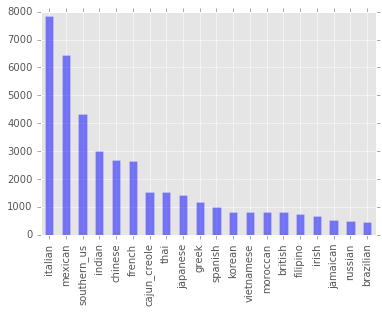

In [34]:
df.cuisine.value_counts().plot(kind='bar', alpha=0.5)

The 20 most common ingredients

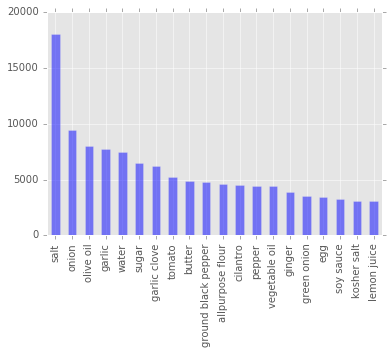

In [32]:
stacked_ingredients.value_counts()[0:20].plot(kind='bar', alpha=0.5)